***Project Introduction and Motivation***

***Project Goal: Predicting Medical Claim Outcomes***
* ***This project focuses on a core challenge in US healthcare finance: predicting the final status of a medical claim.***

*  ***When US citizens visit a healthcare provider, the provider submits a claim to the patient's insurance company (the payer). If the treatment cost exceeds a small patient co-payment, the claim must be processed by the insurer. Our mission is to accurately predict the outcome of this process using machine learning.***

***We are predicting the claim's status into one of three critical categories:***

* ***Paid: The claim is approved and settled by the payer.***
* ***Denied: The claim is rejected, often due to missing documentation or coding errors.***
* ***Pending: The claim is held up, requiring further review or information.***

***The main hurdle was finding a realistic dataset. I solved this by first designing the comprehensive business rules and logic (covering eligibility, late filing, and billing discrepancies) and then implementing a synthetic data generator using Python with assistance from an AI coding tool.***

***Using this realistic data, we are applying advanced algorithms—specifically Random Forest, XGBoost, and an Artificial Neural Network (ANN)—to build a powerful predictive model.***


***Step 1: Importing Libraries - Setting up the ML Toolbox***

In [ ]:
# Standard Data Handling and Math
import pandas as pd
import numpy as np

# Data Visualization (Crucial for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE # Used for handling imbalanced data

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Neural Network (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Model Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

***Step 2: Load the dataset from drive***

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/final_claims_data_industry.csv")
data.head()

,ClaimID,MemberID,ProviderNPI,AccountNum,TaxID,DateOfService,BilledAmount,AllowedAmount,Is_Out_Of_Network,Days_to_File,Is_Policy_Active,PatientAge,PatientGender,ProviderSpecialty,ClaimStatus
0,cc85ba35-976f-4b9b-a20e-db0116fa458b,M02994,P0468,262944,18181,2023-01-01,5966.621342,5648.867813,False,41,True,19,M,Physical Therapy,Pending
1,7e1f1e53-d3ac-4ba9-81fa-797aed947b6d,M04487,P0527,721054,29300,2023-02-03,10728.760158,10172.484782,False,45,True,41,F,Radiology,Pending
2,242e8a36-3dc4-4636-bbdf-d5e996123b35,M04672,P0577,887824,53800,2023-12-10,8202.066506,5194.960300,True,0,True,11,F,Physical Therapy,Pending
3,8d62fcdd-1f5f-4acb-aca2-105d84f70008,M04896,P0579,985889,17618,2023-01-11,9287.788171,8777.170514,False,0,True,53,F,Radiology,Paid
4,07e82a6e-d8d6-438e-8f3d-91d2cc1723e1,M02676,P0041,916871,90543,2023-05-06,12218.887462,11394.763581,False,0,True,33,F,Cardiology,Paid


***Step 3: Data pre-processing***

***Info will show if there are any null values and the data types of each column( No null values )***

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ClaimID            10000 non-null  object 
 1   MemberID           10000 non-null  object 
 2   ProviderNPI        10000 non-null  object 
 3   AccountNum         10000 non-null  int64  
 4   TaxID              10000 non-null  int64  
 5   DateOfService      10000 non-null  object 
 6   BilledAmount       10000 non-null  float64
 7   AllowedAmount      10000 non-null  float64
 8   Is_Out_Of_Network  10000 non-null  bool   
 9   Days_to_File       10000 non-null  int64  
 10  Is_Policy_Active   10000 non-null  bool   
 11  PatientAge         10000 non-null  int64  
 12  PatientGender      10000 non-null  object 
 13  ProviderSpecialty  10000 non-null  object 
 14  ClaimStatus        10000 non-null  object 
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 1.0+ MB


***Step 4: We must first inspect the distribution of our target variable, ClaimStatus Let's check whether it's a single-class or multi-class classification problem***

In [ ]:
data["ClaimStatus"].unique()

array(['Pending', 'Paid', 'Denied'], dtype=object)

***Step 5: Target Variable Distribution***
***We found that the dependent variable is a multi-class classification and the class distribution is slightly uneven but acceptable for modeling.***

In [ ]:
data.value_counts("ClaimStatus")

,count
ClaimStatus,
Paid,4069
Pending,3474
Denied,2457


***Data Visualization - We use a count plot to visualize the counts for Denied, Paid, and Pending claims.***

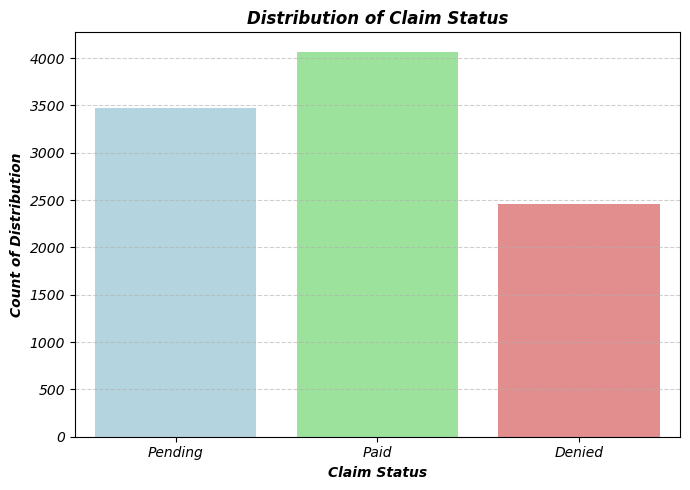

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(x="ClaimStatus", data=data, hue="ClaimStatus", palette=["lightblue", "lightgreen", "lightcoral"])
plt.title('Distribution of Claim Status', fontstyle = "italic", weight="bold")
plt.xlabel("Claim Status", fontstyle = "italic", weight="bold")
plt.ylabel("Count of Distribution", fontstyle = "italic", weight="bold")
plt.xticks( fontstyle = "italic")
plt.yticks( fontstyle = "italic")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

*   ***Step 6: Descriptive Statistics***

*   ***The describe function gives a statistical summary of all numeric columns. BilledAmount and AllowedAmount show wide ranges and high standard deviations, indicating variability in claim sizes. Days_to_File ranges from 0 to 255, with a median of 25, suggesting some claims are filed very late. PatientAge spans from 1 to 89, with a mean around 45, showing a mix of younger and older patients. This summary helps us understand the scale and spread of the data before applying transformations or modeling.***

In [ ]:
data.describe()

,AccountNum,TaxID,BilledAmount,AllowedAmount,Days_to_File,PatientAge
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,549469.244600,55106.579800,7748.370451,6722.062690,34.757300,45.204100
std,261157.350858,25939.659784,4204.854638,3806.880226,37.152833,25.725641
min,100259.000000,10010.000000,502.362390,283.778612,0.000000,1.000000
25%,320932.250000,32568.000000,4105.838009,3426.012918,0.000000,23.000000
50%,548338.500000,54886.000000,7775.030799,6584.639932,25.000000,45.000000
75%,775684.750000,77718.500000,11377.286384,9809.451051,58.000000,68.000000
max,999919.000000,99991.000000,14994.941691,14209.235696,255.000000,89.000000


***Step 7: This box plot helps us visually inspect the spread and outliers in key numeric features. BilledAmount and AllowedAmount show symmetric distributions with no visible outliers, indicating stable claim values. Days_to_File has several outliers on the higher end, confirming that some claims are filed very late and may need special handling. PatientAge appears balanced and clean, with no extreme values. This visual confirms the descriptive statistics and helps us decide how to treat outliers and prepare the data for modeling.***

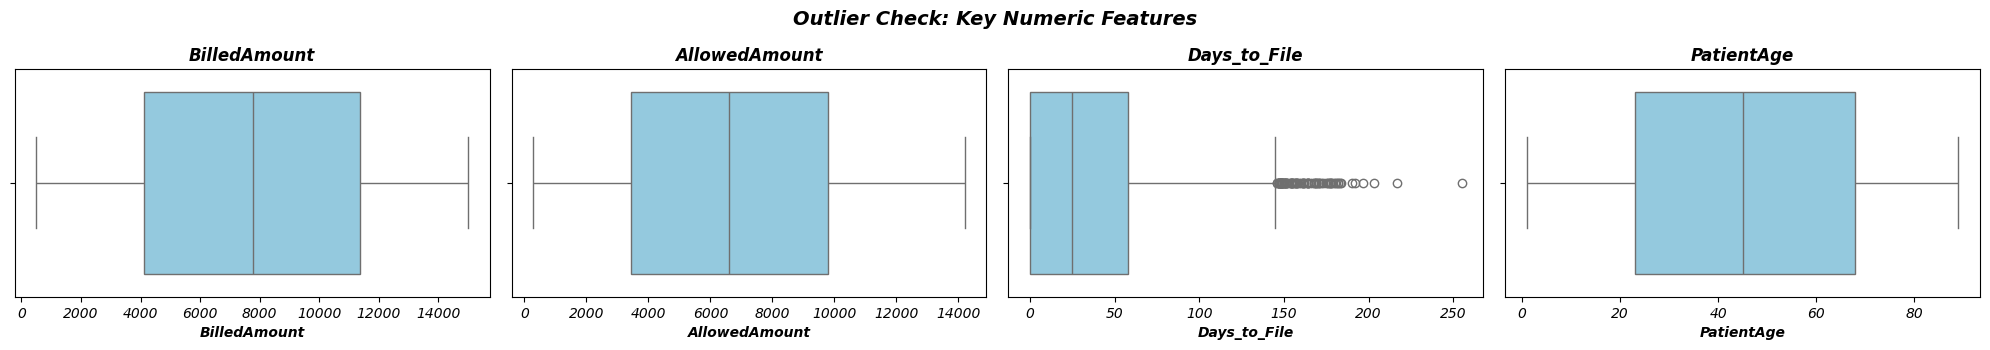

In [ ]:
numeric_cols = ['BilledAmount', 'AllowedAmount', 'Days_to_File', 'PatientAge']

plt.figure(figsize=(20, 6))

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x = data[col], color='skyblue')
    plt.title(f"{col}", fontsize=12, style='italic', weight='bold')
    plt.xlabel(col, fontsize=10, style='italic', weight='bold')
    plt.xticks(style='italic')

plt.suptitle("Outlier Check: Key Numeric Features", style='italic', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


***Step 8: Data Cleaning: Dropping Non-Predictive Columns***
*   ***Prevent Overfitting: These columns have no true predictive power. If the model uses them, it essentially memorizes $10,000$ unique identifiers, which will lead to perfect performance on the training data but terrible performance on any new, unseen data.***
*   ***Noise Reduction: These unique values act as "noise" that distracts the model from finding the real patterns in the remaining features.***
*   ***The DateOfService column is also dropped here, as we will replace it with more useful engineered features in the next step.***

In [ ]:
drop_cols = ['ClaimID', 'MemberID', 'ProviderNPI', 'AccountNum', 'TaxID', 'DateOfService']
data = data.drop(columns=drop_cols)
print(data.columns.tolist())

['BilledAmount', 'AllowedAmount', 'Is_Out_Of_Network', 'Days_to_File', 'Is_Policy_Active', 'PatientAge', 'PatientGender', 'ProviderSpecialty', 'ClaimStatus']


***Step 9: Feature Engineering:***
*   ***This is a core concept in claims data. We are creating a new, highly informative feature by combining two existing ones. The ratio of the Billed Amount (what the provider asked for) to the Allowed Amount (what the payer agrees to pay) is often the single strongest predictor of whether a claim will be denied or pending.***
*   ***A ratio close to 1.0 usually means the claim is clean.***
*   ***A ratio significantly greater than 1.0 (Billed much higher than Allowed) suggests a potential issue that could lead to a 'Denied' or 'Pending' status.***
*   ***Additionally, this transformation helps reduce multicollinearity between BilledAmount and AllowedAmount, since both are highly correlated. By combining them into a single ratio, we reduce redundancy and provide the model with a more stable and interpretable signal.***

In [ ]:
data['BilledToAllowedRatio'] = data['BilledAmount']/(data['AllowedAmount']+1)
print("\n--- Descriptive Statistics for New Feature ---")
print(data['BilledToAllowedRatio'].describe())


--- Descriptive Statistics for New Feature ---
count    10000.000000
mean         1.185703
std          0.229045
min          1.051046
25%          1.069923
50%          1.088034
75%          1.106585
max          1.999432
Name: BilledToAllowedRatio, dtype: float64


***Step 10 : Feature Engineering: Categorical Patient Age Group***
*   ***The raw PatientAge is a continuous number. While machine learning models can handle this, it's often more robust to turn it into categorical groups (a process called binning).***
*   ***Improved Generalization: The model learns that claims for patients in the 'Senior' group behave in a certain way, rather than having to learn the specific pattern for age $65$, age $66$, etc. This reduces complexity and noise.***
*   ***We then drop the original PatientAge column because the new binned column is now more informative.***

In [ ]:
bins = [0, 18, 45, 65, 100]
lables = ['child/young','Adult','senior','Elderly']
data['PatientAgeGroup'] = pd.cut(data['PatientAge'],bins=bins,labels=lables,right=False).astype=object
data = data.drop(columns=['PatientAge'])

***Step 11 : Data Type Conversion and Categorical Visualization Check.***

***Type Consistency: We ensure our Boolean features (Is_Policy_Active, Is_Out_Of_Network) are explicitly cast to object (categorical) so they are correctly handled by the upcoming One-Hot Encoding process.***

***Visualization Necessity: We must visualize the relationship between key categorical features and the target variable, such as ProviderSpecialty, to confirm its predictive value. The visual below clearly shows that certain specialties have a higher volume of claims, and the distribution of Paid/Denied/Pending varies by specialty, confirming this is a valuable feature.***

Final Data Types Check:
BilledAmount            float64
AllowedAmount           float64
Is_Out_Of_Network        object
Days_to_File              int64
Is_Policy_Active         object
PatientGender            object
ProviderSpecialty        object
ClaimStatus              object
BilledToAllowedRatio    float64
PatientAgeGroup          object
dtype: object


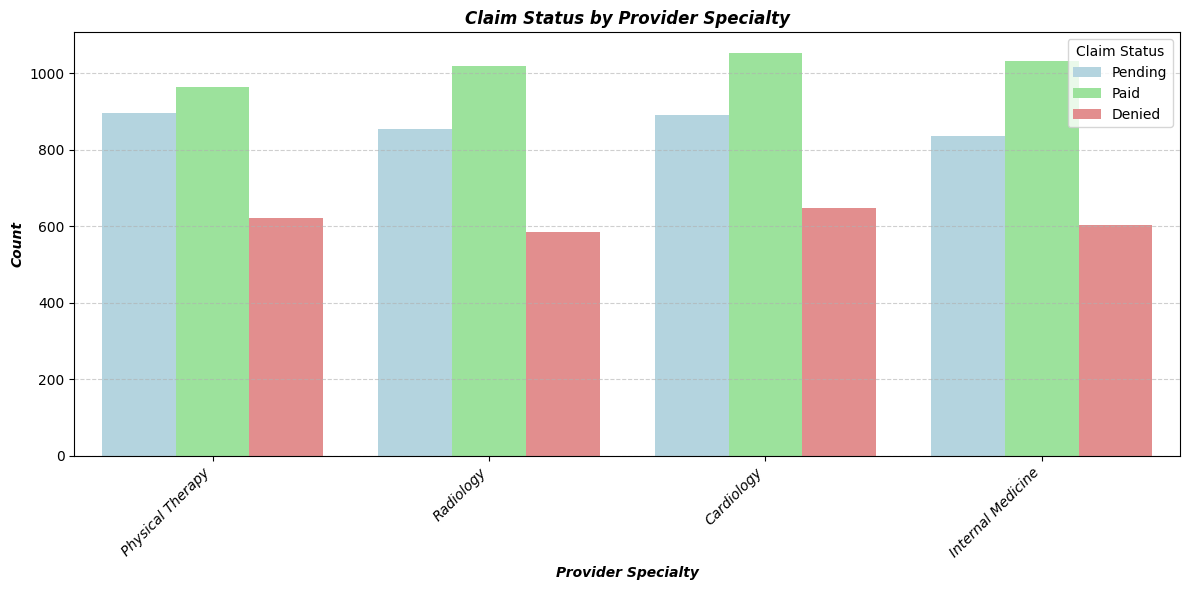

In [ ]:
data['Is_Policy_Active'] = data['Is_Policy_Active'].astype(object)
data['Is_Out_Of_Network'] = data['Is_Out_Of_Network'].astype(object)

print("Final Data Types Check:")
print(data.dtypes)

plt.figure(figsize=(12, 6))
sns.countplot(
    data=data,
    x='ProviderSpecialty',
    hue='ClaimStatus',
    palette=["lightblue", "lightgreen", "lightcoral"]
)
plt.title('Claim Status by Provider Specialty', fontstyle='italic', weight='bold')
plt.xlabel("Provider Specialty", fontstyle='italic', weight='bold')
plt.ylabel("Count", fontstyle='italic', weight='bold')
plt.xticks(rotation=45, ha='right', fontstyle='italic')
plt.legend(title='Claim Status')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

***Now lets see how the data looks***

In [ ]:
data.head()

,BilledAmount,AllowedAmount,Is_Out_Of_Network,Days_to_File,Is_Policy_Active,PatientGender,ProviderSpecialty,ClaimStatus,BilledToAllowedRatio,PatientAgeGroup
0,5966.621342,5648.867813,False,41,True,M,Physical Therapy,Pending,1.056064,<class 'object'>
1,10728.760158,10172.484782,False,45,True,F,Radiology,Pending,1.054581,<class 'object'>
2,8202.066506,5194.960300,True,0,True,F,Physical Therapy,Pending,1.578547,<class 'object'>
3,9287.788171,8777.170514,False,0,True,F,Radiology,Paid,1.058055,<class 'object'>
4,12218.887462,11394.763581,False,0,True,F,Cardiology,Paid,1.072231,<class 'object'>


***Step 11 :  Data Splitting Scaling, and Encoding Setup***

***This is the core preprocessing phase, separating the data and preparing features for the models.***

In [ ]:
X = data.drop(['ClaimStatus'], axis=1)
y = data['ClaimStatus']
X.shape, y.shape

((10000, 9), (10000,))

***Splitting  :  We use a stratified split to ensure the proportion of Paid, Denied, and Pending claims is identical in both the $80\%$ Training and $20\%$ Testing sets.***

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42,stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8000, 9), (2000, 9), (8000,), (2000,))

***Identify column types***

In [ ]:
numeric_cols = x_train.select_dtypes(include=["int64" , "float64"]).columns
categorical_cols = x_train.select_dtypes(include=['object']).columns

***Scaling (StandardScaler): Features like BilledAmount are in the thousands, while Days_to_File is in the hundreds. Scaling standardizes all numerical data (mean  ≈0 , standard deviation  ≈1 ), preventing the model from giving disproportionate weight to features with larger values.***

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test_scaled[numeric_cols] = scaler.transform(x_test[numeric_cols])

***Encoding (OneHotEncoder): Categorical data (like PatientGender or the newly created PatientAgeGroup) must be converted into a numerical format the model can use.***

In [ ]:
x_train_cat = pd.get_dummies(x_train[categorical_cols], drop_first=True)
x_test_cat = pd.get_dummies(x_test[categorical_cols], drop_first=True)
x_test_cat = x_test_cat.reindex(columns=x_train_cat.columns, fill_value=0)

***Feature Consolidation: Merging Scaled Numeric and Encoded Categorical Data***

In [ ]:
x_train_final = pd.concat([x_train_scaled[numeric_cols], x_train_cat], axis=1)
x_test_final = pd.concat([x_test_scaled[numeric_cols], x_test_cat], axis=1)
print(f"Final training features shape: {x_train_final.shape}")
print(f"Final test features shape: {x_test_final.shape}")

Final training features shape: (8000, 10)
Final test features shape: (2000, 10)


***Step 12 : Target Encoding and Synthetic Over-sampling (SMOTE)***
  
***We also apply `LabelEncoder` to convert the target labels (`ClaimStatus`) into numeric format. This prepares the labels for classification models like Random Forest, XGBoost, and ANN.***

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

***SMOTE: It uses the Synthetic Minority Over-sampling Technique (SMOTE) to create new, artificial samples for the minority classes (Denied and Pending). The goal is to make all classes equally represented in the training set.***

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_bal, y_train_bal = smote.fit_resample(x_train_final, y_train_enc)

***Normalized Data***

In [ ]:
x_train_final.head()

,BilledAmount,AllowedAmount,Days_to_File,BilledToAllowedRatio,Is_Out_Of_Network_True,Is_Policy_Active_True,PatientGender_M,ProviderSpecialty_Internal Medicine,ProviderSpecialty_Physical Therapy,ProviderSpecialty_Radiology
4193,-1.046576,-0.963913,-0.097462,-0.389471,False,False,True,True,False,False
985,1.547290,1.615734,0.497497,-0.341976,False,True,True,True,False,False
2517,-1.086746,-1.004518,-0.935813,-0.388612,False,True,True,False,False,False
39,-1.189566,-1.110862,-0.638333,-0.368330,False,True,True,True,False,False
6297,1.674647,1.846210,-0.043375,-0.480808,False,True,True,False,False,False


In [ ]:
np.unique(y_train_enc)

array([0, 1, 2])

***Normalized Data***

In [ ]:
x_test_final.head()

,BilledAmount,AllowedAmount,Days_to_File,BilledToAllowedRatio,Is_Out_Of_Network_True,Is_Policy_Active_True,PatientGender_M,ProviderSpecialty_Internal Medicine,ProviderSpecialty_Physical Therapy,ProviderSpecialty_Radiology
45,1.679228,1.025754,-0.935813,0.910871,True,True,True,True,False,False
2929,0.374605,0.531010,0.254105,-0.521495,False,True,False,False,False,True
7115,0.414026,0.598168,0.010713,-0.573453,False,True,False,False,False,False
6389,1.471337,1.648848,-0.421985,-0.496563,False,False,True,False,False,False
868,0.297052,0.426799,0.822020,-0.470688,False,True,True,True,False,False


In [ ]:
np.unique(y_test_enc)

array([0, 1, 2])

***Step 13 : To understand relationships between numeric features, we use a correlation heatmap. This helps identify patterns, feature importance.***

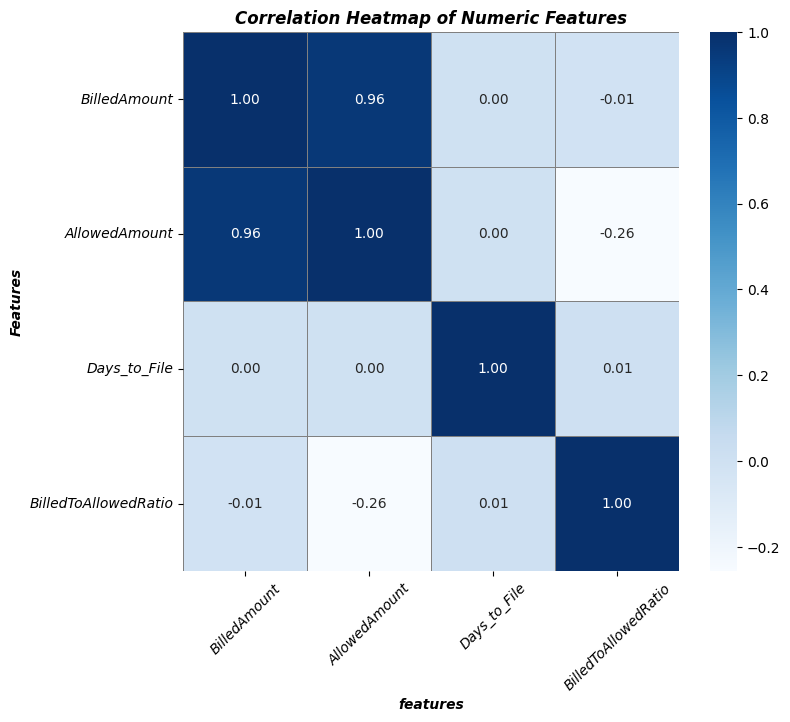

In [ ]:
plt.figure(figsize=(8,7))
sns.heatmap(data.corr(numeric_only=True),annot=True, cmap='Blues',fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("Correlation Heatmap of Numeric Features", fontstyle="italic", weight="bold")
plt.xlabel('features',fontstyle="italic",weight="bold")
plt.ylabel("Features", fontstyle="italic",weight="bold")
plt.xticks(fontstyle="italic",rotation=45)
plt.yticks(fontstyle="italic",rotation=0)
plt.show()

***Step 14 : ANN Prep: to_categorical converts the numerical labels (0, 1, 2) into One-Hot Encoded vectors (e.g., $0 \rightarrow [1, 0, 0]$), which is a format required for the output layer of the Neural Network.***

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train_bal, num_classes=3)
y_test_onehot = to_categorical(y_test_enc,num_classes=3)

print("\nClass Distribution After SMOTE (y_train_bal):")
print(pd.Series(y_train_bal).value_counts())


Class Distribution After SMOTE (y_train_bal):
0    3255
1    3255
2    3255
Name: count, dtype: int64


***Step 14  : Model Training and Evaluation: Random Forest***

***Random Forest Hyperparameter Tuning***

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*50)
print("STARTING RANDOM FOREST TRAINING")
print("="*50)

rf = RandomForestClassifier(
    n_estimators=1500,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(x_train_bal,y_train_bal)
rf_preds = rf.predict(x_test_final)
rf_acc = accuracy_score(y_test_enc,rf_preds)

print("\n=== OPTIMIZED RANDOM FOREST RESULTS ===")
print(f"Accuracy (RF): {round(rf_acc, 4)}")
print(classification_report(y_test_enc, rf_preds))
print("Confusion Matrix (RF):\n", confusion_matrix(y_test_enc, rf_preds))
print("----------------------------------------------------------------")


STARTING RANDOM FOREST TRAINING

=== OPTIMIZED RANDOM FOREST RESULTS ===
Accuracy (RF): 0.7395
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       491
           1       0.87      0.88      0.87       814
           2       0.61      0.68      0.64       695

    accuracy                           0.74      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.74      0.74      0.74      2000

Confusion Matrix (RF):
 [[293   0 198]
 [  0 715  99]
 [114 110 471]]
----------------------------------------------------------------


***Step 15 : Model Training and Evaluation : XGBoost***

***XGBoost Hyperparameter Tuning***

***It trains an XGBoost (Extreme Gradient Boosting) model. XGBoost is a boosting algorithm that builds trees sequentially, where each new tree tries to correct the errors made by the previous trees.***

In [ ]:
from xgboost import XGBClassifier

print("\n" + "="*50)
print("STARTING XGBOOST TRAINING")
print("="*50)

xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgb.fit(x_train_bal, y_train_bal)
xgb_preds = xgb.predict(x_test_final)
xgb_acc = accuracy_score(y_test_enc, xgb_preds)

print("\n=== OPTIMIZED XGBOOST RESULTS ===")
print(f"Accuracy (XGB): {round(xgb_acc, 4)}")
print(classification_report(y_test_enc, xgb_preds))
print("Confusion Matrix (XGB):\n", confusion_matrix(y_test_enc, xgb_preds))
print("----------------------------------------------------------------")


STARTING XGBOOST TRAINING


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:27:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== OPTIMIZED XGBOOST RESULTS ===
Accuracy (XGB): 0.739
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       491
           1       0.86      0.89      0.87       814
           2       0.62      0.64      0.63       695

    accuracy                           0.74      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.74      0.74      0.74      2000

Confusion Matrix (XGB):
 [[312   0 179]
 [  0 723  91]
 [132 120 443]]
----------------------------------------------------------------


***Step 16 : Model Training and Evaluation: Artificial Neural Network (ANN)***

***It builds a simple Sequential Neural Network with multiple hidden layers and trains it using the balanced data.***

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

print("\n" + "="*50)
print("STARTING ARTIFICIAL NEURAL NETWORK (ANN) TRAINING")
print("="*50)

input_dim = x_train_bal.shape[1]
output_classes = y_train_onehot.shape[1]

ann_model = Sequential()
ann_model.add(Dense(units=128, activation='relu', input_shape=(input_dim,)))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(units=64, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(units=32, activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=output_classes, activation='softmax'))

ann_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = ann_model.fit(
    x_train_bal, y_train_onehot,
    batch_size=32,
    epochs=200,
    validation_data=(x_test_final, y_test_onehot),
    verbose=0
)

loss, ann_acc = ann_model.evaluate(x_test_final, y_test_onehot, verbose=0)
ann_preds_prob = ann_model.predict(x_test_final, verbose=0)
ann_preds = np.argmax(ann_preds_prob, axis=1)

print("\n=== ARTIFICIAL NEURAL NETWORK (ANN) RESULTS ===")
print(f"ANN Accuracy: {ann_acc:.4f}")
print(classification_report(y_test_enc, ann_preds))
print("Confusion Matrix (ANN):\n", confusion_matrix(y_test_enc, ann_preds))
print("="*50 + "\n")


STARTING ARTIFICIAL NEURAL NETWORK (ANN) TRAINING


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== ARTIFICIAL NEURAL NETWORK (ANN) RESULTS ===
ANN Accuracy: 0.7620
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       491
           1       0.89      0.87      0.88       814
           2       0.63      0.75      0.69       695

    accuracy                           0.76      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.77      0.76      0.76      2000

Confusion Matrix (ANN):
 [[294   0 197]
 [  0 710 104]
 [ 91  84 520]]



***Project Conclusion***

***Conclusion and Final Model Performance***

***We successfully executed a complete machine learning pipeline for classifying medical claims. The workflow included crucial steps like dropping non-predictive features, creating high-value Feature Engineering (like the BilledToAllowedRatio), applying Standard Scaling, and using SMOTE to balance the training data.***

***The Artificial Neural Network proved to be the top performer, achieving the highest accuracy. While overall performance is strong, the model's main weakness lies in the Recall of Denied claims (Class 0). The next steps for optimization would involve techniques like Focal Loss or Class Weighting to specifically boost the prediction rate for these crucial minority classes.***